In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [3]:
#Other necessary imports
import matplotlib.pyplot as plt
from sklearn.utils import compute_class_weight
from PIL import Image
import keras
from keras import models
from keras import layers
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Defining a results visualization function
def visualize_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    #Instantiate values
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    train_recall = history.history['recall']
    train_aucroc = history.history['auc']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    val_recall = history.history['val_recall']
    val_aucroc = history.history['val_auc']
    
    #Create figure for plotting
    fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Results')
    #plt.xlabel('Epoch')
    
    #Plot Loss
    ax1.plot(train_loss)
    ax1.plot(val_loss)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epochs')
    ax1.legend(['train', 'val'])
    
    #Plot Accuracy
    ax2.plot(train_acc)
    ax2.plot(val_acc)
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend(['train', 'val'])
    
    #Plot Recall
    ax3.plot(train_recall)
    ax3.plot(val_recall)
    ax3.set_ylabel('Recall')
    ax3.set_xlabel('Epochs')
    ax3.legend(['train', 'val'])
    
    #Plot AUC-ROC
    ax4.plot(train_aucroc)
    ax4.plot(val_aucroc)
    ax4.set_ylabel('AUC-ROC')
    ax4.set_xlabel('Epochs')
    ax4.legend(['train', 'val'])
    
    plt.show();

# Load Processed Data

In [5]:
#Load data
train_images = np.load('../input/eda-and-data-preprocessing/train_images.npy')
train_labels = np.load('../input/eda-and-data-preprocessing/train_labels.npy')

train_images_third = np.load('../input/eda-and-data-preprocessing/train_images_third.npy')
train_labels_third = np.load('../input/eda-and-data-preprocessing/train_labels_third.npy')

val_images = np.load('../input/eda-and-data-preprocessing/val_images.npy')
val_labels = np.load('../input/eda-and-data-preprocessing/val_labels.npy')

test_images = np.load('../input/eda-and-data-preprocessing/test_images.npy')
test_labels = np.load('../input/eda-and-data-preprocessing/test_labels.npy')

In [6]:
#Explore the dataset again
print ("Number of training samples: " + str(train_images.shape[0]))
print ("A third of training samples: " + str(train_images_third.shape[0]))
print ("Number of validation samples: " + str(val_images.shape[0]))
print ("Number of testing samples: " + str(test_images.shape[0]))
print ("===")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("A third of train_images shape: " + str(train_images_third.shape))
print ("A third of train_labels shape: " + str(train_labels_third.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 25803
A third of training samples: 8601
Number of validation samples: 8602
Number of testing samples: 3823
===
train_images shape: (25803, 128, 128, 3)
train_labels shape: (25803,)
A third of train_images shape: (8601, 128, 128, 3)
A third of train_labels shape: (8601,)
val_images shape: (8602, 128, 128, 3)
val_labels shape: (8602,)
test_images shape: (3823, 128, 128, 3)
test_labels shape: (3823,)


# Modeling

In [7]:
#Build a pretrained vgg16 model
vgg16 = VGG16(weights='imagenet',
                   include_top=False, # Allows us to set input shape
                   input_shape=(128,128,3)) 

2021-12-03 03:24:07.960732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 03:24:08.107614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 03:24:08.108759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 03:24:08.110600: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
#Get the vgg16 model
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [9]:
#Add vgg16 to our pretrained model
vgg16_model_balanced = keras.models.Sequential()
vgg16_model_balanced.add(vgg16)

#Freezing layers so they don't get re-trained with your new data
for layer in vgg16_model_balanced.layers:
    layer.trainable=False 
    
#Adding our own dense layers
vgg16_model_balanced.add(layers.Flatten())
vgg16_model_balanced.add(layers.Dense(128, activation='relu'))

#Output Layer
vgg16_model_balanced.add(layers.Dense(1, activation='sigmoid'))

In [10]:
#Summary of our vgg16 model
vgg16_model_balanced.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
#Compile vgg16 model
vgg16_model_balanced.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'Recall', 'AUC'])

#Instantiate an EarlyStopping Object
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
mc = ModelCheckpoint('best_vgg16_model_balanced.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

#Compute class weight to help with imbalanced target
classWeight = compute_class_weight('balanced', np.unique(train_labels_third), train_labels_third) 
classWeight = dict(enumerate(classWeight))

#And fit the cnn model to the training images, validating on the val images
results = vgg16_model_balanced.fit(train_images_third,
                            train_labels_third,
                            epochs=50,
                            batch_size=32,
                            class_weight = classWeight,
                            callbacks = [es,mc],
                            validation_data=(val_images, val_labels))

2021-12-03 03:24:14.494728: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691025408 exceeds 10% of free system memory.
2021-12-03 03:24:16.122954: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691025408 exceeds 10% of free system memory.
2021-12-03 03:24:17.407847: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-12-03 03:24:19.867842: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


269/269 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.8511 - recall: 0.8116 - auc: 0.9122

2021-12-03 03:24:37.305147: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691222016 exceeds 10% of free system memory.
2021-12-03 03:24:39.110304: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1691222016 exceeds 10% of free system memory.


269/269 [==============================] - 31s 81ms/step - loss: 0.3710 - accuracy: 0.8511 - recall: 0.8116 - auc: 0.9122 - val_loss: 0.2750 - val_accuracy: 0.9007 - val_recall: 0.8405 - val_auc: 0.9445

Epoch 00001: val_recall improved from -inf to 0.84050, saving model to best_vgg16_model_balanced.h5
Epoch 2/50
269/269 [==============================] - 13s 49ms/step - loss: 0.2625 - accuracy: 0.8962 - recall: 0.8747 - auc: 0.9577 - val_loss: 0.2487 - val_accuracy: 0.9033 - val_recall: 0.8546 - val_auc: 0.9498

Epoch 00002: val_recall improved from 0.84050 to 0.85457, saving model to best_vgg16_model_balanced.h5
Epoch 3/50
269/269 [==============================] - 14s 50ms/step - loss: 0.2288 - accuracy: 0.9099 - recall: 0.8998 - auc: 0.9679 - val_loss: 0.3690 - val_accuracy: 0.8453 - val_recall: 0.9163 - val_auc: 0.9500

Epoch 00003: val_recall improved from 0.85457 to 0.91634, saving model to best_vgg16_model_balanced.h5
Epoch 4/50
269/269 [==============================] - 13s 49

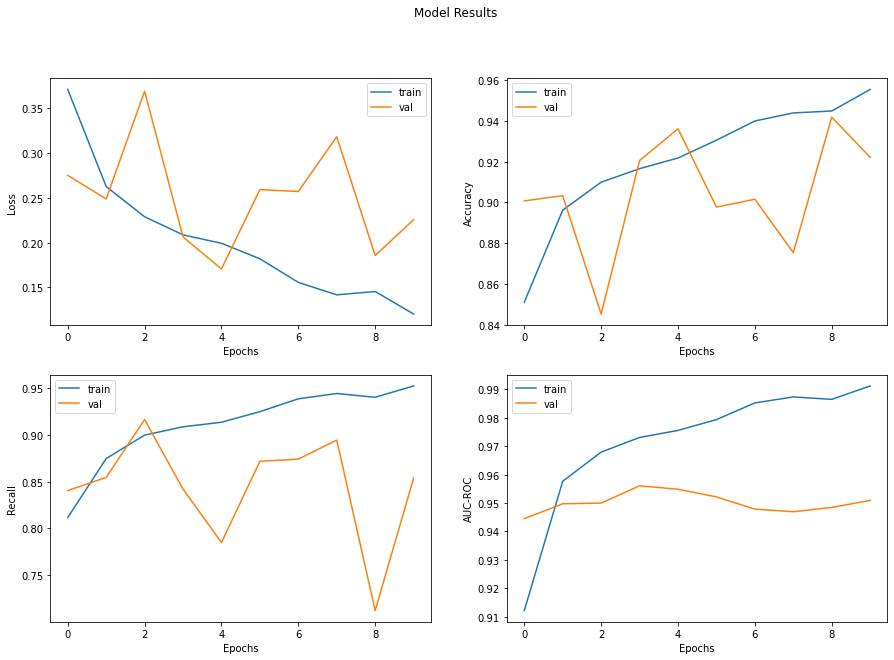

In [12]:
#Visualize Results 
visualize_results(results)

In [13]:
#Save Weights
vgg16_model_balanced.save_weights('vgg16_model_balanced_weights.h5')